<a href="https://colab.research.google.com/github/DimaKav/DS-Sprint-01-Dealing-With-Data/blob/master/module4-databackedassertions/LS_DS_114_Making_Data_backed_Assertions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science - Making Data-backed Assertions

This is, for many, the main point of data science - to create and support reasoned arguments based on evidence. It's not a topic to master in a day, but it is worth some focused time thinking about and structuring your approach to it.

## Lecture - generating a confounding variable

The prewatch material told a story about a hypothetical health condition where both the drug usage and overall health outcome were related to gender - thus making gender a confounding variable, obfuscating the possible relationship between the drug and the outcome.

Let's use Python to generate data that actually behaves in this fashion!

In [1]:
import random
dir(random)  # Reminding ourselves what we can do here

['BPF',
 'LOG4',
 'NV_MAGICCONST',
 'RECIP_BPF',
 'Random',
 'SG_MAGICCONST',
 'SystemRandom',
 'TWOPI',
 '_BuiltinMethodType',
 '_MethodType',
 '_Sequence',
 '_Set',
 '__all__',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_acos',
 '_bisect',
 '_ceil',
 '_cos',
 '_e',
 '_exp',
 '_inst',
 '_itertools',
 '_log',
 '_pi',
 '_random',
 '_sha512',
 '_sin',
 '_sqrt',
 '_test',
 '_test_generator',
 '_urandom',
 '_warn',
 'betavariate',
 'choice',
 'choices',
 'expovariate',
 'gammavariate',
 'gauss',
 'getrandbits',
 'getstate',
 'lognormvariate',
 'normalvariate',
 'paretovariate',
 'randint',
 'random',
 'randrange',
 'sample',
 'seed',
 'setstate',
 'shuffle',
 'triangular',
 'uniform',
 'vonmisesvariate',
 'weibullvariate']

In [2]:
# Let's think of another scenario:
# We work for a company that sells accessories for mobile phones.
# They have an ecommerce site, and we are supposed to analyze logs
# to determine what sort of usage is related to purchases, and thus guide
# website development to encourage higher conversion.

# The hypothesis - users who spend longer on the site tend
# to spend more. Seems reasonable, no?

# But there's a confounding variable! If they're on a phone, they:
# a) Spend less time on the site, but
# b) Are more likely to be interested in the actual products!

# Let's use namedtuple to represent our data

from collections import namedtuple
# purchased and mobile are bools, time_on_site in seconds
User = namedtuple('User', ['purchased','time_on_site', 'mobile'])

example_user = User(False, 12, False)
print(example_user)

User(purchased=False, time_on_site=12, mobile=False)


In [3]:
# And now let's generate 1000 example users
# 750 mobile, 250 not (i.e. desktop)
# A desktop user has a base conversion likelihood of 10%
# And it goes up by 1% for each 15 seconds they spend on the site
# And they spend anywhere from 10 seconds to 10 minutes on the site (uniform)
# Mobile users spend on average half as much time on the site as desktop
# But have twice as much base likelihood of buying something

users = []

for _ in range(250):
  # Desktop users
  time_on_site = random.uniform(10, 600)
  purchased = random.random() < 0.1 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, False))
  
for _ in range(750):
  # Mobile users
  time_on_site = random.uniform(5, 300)
  purchased = random.random() < 0.2 + (time_on_site // 1500)
  users.append(User(purchased, time_on_site, True))
  
random.shuffle(users)
print(users[:10])

[User(purchased=False, time_on_site=34.53906894188046, mobile=True), User(purchased=False, time_on_site=196.33993993256905, mobile=True), User(purchased=False, time_on_site=21.89660305798923, mobile=True), User(purchased=False, time_on_site=266.5945676331252, mobile=True), User(purchased=False, time_on_site=208.00112610567976, mobile=True), User(purchased=False, time_on_site=191.0927793120738, mobile=True), User(purchased=False, time_on_site=62.026045661250414, mobile=True), User(purchased=True, time_on_site=177.43710989095524, mobile=True), User(purchased=False, time_on_site=383.48766695407926, mobile=False), User(purchased=True, time_on_site=223.73224582679913, mobile=True)]


In [27]:
# Let's put this in a dataframe so we can look at it more easily
import pandas as pd
user_data = pd.DataFrame(users)
user_data.head(20)

,purchased,time_on_site,mobile
0,False,34.539069,True
1,False,196.339940,True
2,False,21.896603,True
3,False,266.594568,True
4,False,208.001126,True
5,False,191.092779,True
6,False,62.026046,True
7,True,177.437110,True
8,False,383.487667,False
9,True,223.732246,True


In [0]:
# Let's use crosstabulation to try to see what's going on
pd.crosstab(user_data['purchased'], user_data['time_on_site'])

time_on_site,5.2109450715984105,5.464638207539852,5.513221235103223,5.641149731239146,5.74997630784716,5.889838003482058,6.284004561260051,6.829960631216221,7.02578113512759,7.151369999976382,...,581.3393098400824,582.0080169010536,582.0361052263339,582.3490557355324,583.6166002395104,589.1527437334952,589.7271186218869,590.4120394256123,592.1207160828138,595.1646715124776
purchased,,,,,,,,,,,,,,,,,,,,,
False,1,1,1,0,1,1,1,0,1,1,...,1,1,1,1,1,1,1,1,1,1
True,0,0,0,1,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [0]:
# OK, that's not quite what we want
# Time is continuous! We need to put it in discrete buckets
# Pandas calls these bins, and pandas.cut helps make them

time_bins = pd.cut(user_data['time_on_site'], 5)  # 5 equal-sized bins
pd.crosstab(user_data['purchased'], time_bins)

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,258,304,178,43,60
True,60,61,23,7,6


In [0]:
# We can make this a bit clearer by normalizing (getting %)
pd.crosstab(user_data['purchased'], time_bins, normalize='columns')

time_on_site,"(4.621, 123.202]","(123.202, 241.192]","(241.192, 359.183]","(359.183, 477.174]","(477.174, 595.165]"
purchased,,,,,
False,0.811321,0.832877,0.885572,0.86,0.909091
True,0.188679,0.167123,0.114428,0.14,0.090909


In [0]:
# That seems counter to our hypothesis
# More time on the site seems to have fewer purchases

# But we know why, since we generated the data!
# Let's look at mobile and purchased
pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns')

mobile,False,True
purchased,,
False,0.912,0.82
True,0.088,0.18


In [34]:
series = pd.cut(user_data['time_on_site'], 5)
user_data['bin'] = series

for b in user_data.bin.unique():
  print(user_data[user_data.bin == b].head())

    purchased  time_on_site  mobile               bin
0       False     34.539069    True  (4.452, 123.706]
2       False     21.896603    True  (4.452, 123.706]
6       False     62.026046    True  (4.452, 123.706]
12      False    108.073869    True  (4.452, 123.706]
15      False     61.206240    True  (4.452, 123.706]
   purchased  time_on_site  mobile                 bin
1      False    196.339940    True  (123.706, 242.367]
4      False    208.001126    True  (123.706, 242.367]
5      False    191.092779    True  (123.706, 242.367]
7       True    177.437110    True  (123.706, 242.367]
9       True    223.732246    True  (123.706, 242.367]
    purchased  time_on_site  mobile                 bin
3       False    266.594568    True  (242.367, 361.028]
11      False    326.293655   False  (242.367, 361.028]
19      False    307.116126   False  (242.367, 361.028]
28       True    243.372688    True  (242.367, 361.028]
32      False    286.657038    True  (242.367, 361.028]
    purcha

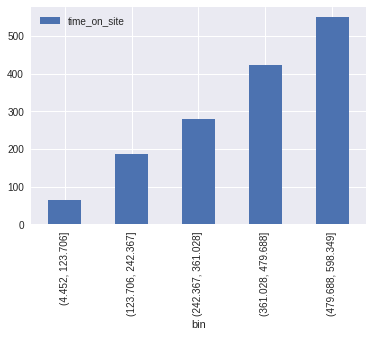

In [35]:
pd.pivot_table(
    user_data, values='time_on_site', index='bin').plot.bar();

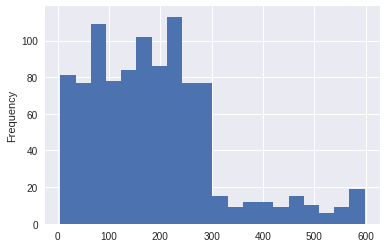

In [36]:
user_data['time_on_site'].plot.hist(bins=20)

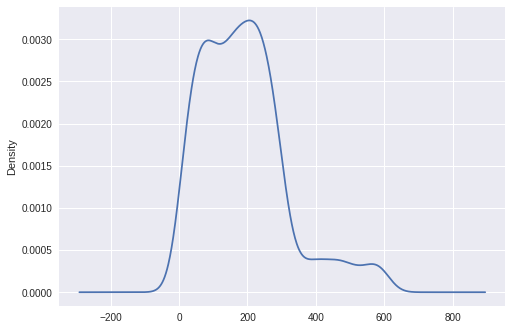

In [31]:
# Yep, mobile users are more likely to buy things
# But we're still not seeing the *whole* story until we look at all 3 at once
import matplotlib.pyplot as plt
# Live/stretch goal - how can we do that?



In [37]:
# From Chris Luedtke
user_data['purchased_num'] = user_data['purchased'] * 1
df = user_data.groupby(['mobile', 'bin'])['purchased_num'].mean()
df = df.reset_index()
df

,mobile,bin,purchased_num
0,False,"(4.452, 123.706]",0.127660
1,False,"(123.706, 242.367]",0.034483
2,False,"(242.367, 361.028]",0.075472
3,False,"(361.028, 479.688]",0.125000
4,False,"(479.688, 598.349]",0.045455
5,True,"(4.452, 123.706]",0.177852
6,True,"(123.706, 242.367]",0.201835
7,True,"(242.367, 361.028]",0.152000


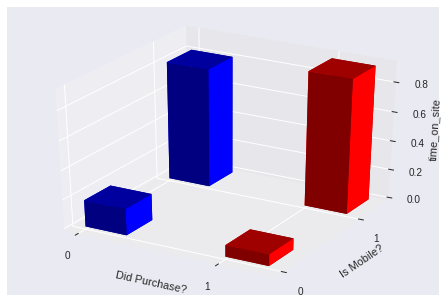

In [32]:
%matplotlib inline

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

data = pd.crosstab(user_data['purchased'], user_data['mobile'], normalize='columns').values

column_names = ['True','False']
row_names = ['True','False']
fig = plt.figure()
ax = Axes3D(fig)

lx= 2 
ly= 2
xpos = np.array([1,0])
ypos = np.array([1,0])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.3 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'b'] * ly

ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color=cs)

ax.axes.set_xticks([1,0])
ax.axes.set_yticks([1,0])
ax.set_xlabel('Did Purchase?')
ax.set_ylabel('Is Mobile?')
ax.set_zlabel('time_on_site')

plt.show()

In [33]:
from mpl_toolkits.mplot3d import Axes3D
import itertools as it
import matplotlib.pyplot as plt
import numpy as np

tab = pd.crosstab(a, [b, c], rownames=['time_bins'], colnames=['purchased', 'mobile'], normalize='index')
data = tab.values

column_names = [str(combination) for combination in it.product(*tab.columns.levels)]
row_names = list(map(lambda l: str(l), tab.index.categories))

fig = plt.figure()
ax = Axes3D(fig)

lx= 4
ly= 5
xpos = np.array([0,1,2,3])
ypos = np.array([0,1,2,3,4])
xpos, ypos = np.meshgrid(xpos, ypos)

xpos = xpos.flatten()
ypos = ypos.flatten()
zpos = np.zeros(lx*ly)

dx = 0.24 * np.ones_like(zpos)
dy = dx.copy()
dz = data.flatten()

cs = ['r', 'g', 'b', 'y'] * ly

ax.bar3d(xpos,ypos,zpos, dx, dy, dz, color=cs)

ax.xaxis._axinfo['label']['space_factor'] = 2.8

ax.w_xaxis.set_ticklabels(column_names)
ax.w_yaxis.set_ticklabels(row_names, linespacing=5)
ax.axes.set_xticks(np.array([0,1,2,3]))
ax.axes.set_yticks(np.array([0,1,2,3,4]))
ax.set_xlabel('(Did Purchase?, Is Mobile?)', labelpad=10)
ax.set_ylabel('Intervals',  labelpad=20)
ax.set_zlabel('time_on_site')

plt.show()

NameError: ignored

## Assignment - what's going on here?

Consider the data in `persons.csv` (already prepared for you, in the repo for the week). It has four columns - a unique id, followed by age (in years), weight (in lbs), and exercise time (in minutes/week) of 1200 (hypothetical) people.

Try to figure out which variables are possibly related to each other, and which may be confounding relationships.

In [0]:
# TODO - your code here
# Use what we did live in lecture as an example

# HINT - you can find the raw URL on GitHub and potentially use that
# to load the data with read_csv, or you can upload it yourself

# Tables and visualizations that caputure relationhsips and tell a story
# Confounding relationships


### Assignment questions

After you've worked on some code, answer the following questions in this text block:

1.  What are the variable types in the data?
2.  What are the relationships between the variables?
3.  Which relationships are "real", and which spurious?


## Stretch goals and resources

Following are *optional* things for you to take a look at. Focus on the above assignment first, and make sure to commit and push your changes to GitHub.

- [Spurious Correlations](http://tylervigen.com/spurious-correlations)
- [NIH on controlling for confounding variables](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4017459/)

Stretch goals:

- Produce your own plot inspierd by the Spurious Correlation visualizations (and consider writing a blog post about it - both the content and how you made it)
- Pick one of the techniques that NIH highlights for confounding variables - we'll be going into many of them later, but see if you can find which Python modules may help (hint - check scikit-learn)